In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile
from collections import defaultdict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)

In [6]:
# simulation output folder
experiment_name = 'test_policy_run_1'

# load Java simulation data
# experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
experiment_folder = fr'..\data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'
collision_output = 'collisionOutputData.csv'

In [7]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [8]:
# function to retrieve any data within the project folder as dataframe
def load_scenario_dataframe(scenario, columns_of_interest, folder, file, input_file):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        #############
        # stop at seed 2
        if seed_name == 'seed_2':
            break
        ###############
        
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # initialise scenario boolean
            row_matches_scenario = False

            # open zip file (remove .csv form file name)
            # check whether input file matches this scenario
            # open input zip file
            with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                # read input csv
                with zip_ref.open(input_file) as input_data_file:
                    df_input = pd.read_csv(input_data_file)
                    row_matches_scenario = all(df_input.iloc[0][key] == value for key, value in scenario.items())
                    
            # get data if input values match this scenario
            if row_matches_scenario:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read data csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number

                        # broadcast input data to all rows in df_interest
                        for col in df_input.columns:
                            df_interest[col] = df_input[col].iloc[0]
                    
                        # add this data to the main DataFrame
                        df = pd.concat([df, df_interest])
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df


# function to retrieve any data within the project folder as dataframe
def load_scenario_collision_dataframe(scenario, folder):
    # collision file
    file = collision_output
    input_file = input_values
    
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # initialise scenario boolean
            row_matches_scenario = False

            # open zip file (remove .csv form file name)
            # check whether input file matches this scenario
            # open input zip file
            with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                # read input csv
                with zip_ref.open(input_file) as input_data_file:
                    df_input = pd.read_csv(input_data_file)
                    row_matches_scenario = all(df_input.iloc[0][key] == value for key, value in scenario.items())
                    
            # get data if input values match this scenario
            if row_matches_scenario:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read data csv
                    with zip_ref.open(file) as data_file:
                        # try to read collision data (will fail when empty)
                        try:
                            df_collisions = pd.read_csv(data_file)
                        # do not process empty collision dataframes
                        except:
                            continue
                        # do process collision  dataframe if it has data
                        print(f'Collisions found in {seed_name}-{run_number}')
                        df_collisions['run'] = run_number

                        # broadcast input data to all rows of collision dataframe
                        for col in df_input.columns:
                            df_collisions[col] = df_input[col].iloc[0]
                    
                        # add this data to the main DataFrame
                        df = pd.concat([df, df_collisions])
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
# filter on follower and leader to get level 0 vehicles in between level 3 vehicles
# and the rest
# do we see difference?

# we now do have a scenario of only humans (scenario 0), only level 3 (scenario 3), and mixed human and level 3 (scenario 4)

In [23]:
# define scenarios
scenario_0 = {
    'level0_fraction': 1.0,
    'level1_fraction': 0.0,
    'level2_fraction': 0.0,
    'level3_fraction': 0.0,
    'in_vehicle_distraction': True,
    'road_side_distraction': False
}

scenario_3 = {
    'level0_fraction': 0.0,
    'level1_fraction': 0.0,
    'level2_fraction': 0.0,
    'level3_fraction': 1.0,
    'in_vehicle_distraction': True,
    'road_side_distraction': False
}

scenario_4 = {
    'level0_fraction': 0.5,
    'level1_fraction': 0.0,
    'level2_fraction': 0.0,
    'level3_fraction': 0.5,
    'in_vehicle_distraction': True,
    'road_side_distraction': False
}

In [24]:
# get scenario data
headway_variables = ['time', 'gtu_id', 'gtu_type', 'headway_time', 'headway_distance', 'leader_gtu_id', 'leader_gtu_type', 'speed', 'acceleration', 'follower_gtu_id', 'x_position', 'lane', 'link']
df_gtu_0 = load_scenario_dataframe(scenario_0, headway_variables, experiment_folder, sequence_output, input_values)
df_gtu_0 = df_gtu_0[headway_variables + ['seed', 'run']]

df_gtu_3 = load_scenario_dataframe(scenario_3, headway_variables, experiment_folder, sequence_output, input_values)
df_gtu_3 = df_gtu_3[headway_variables + ['seed', 'run']]

# df_gtu_4 = load_scenario_dataframe(scenario_4, headway_variables, experiment_folder, sequence_output, input_values)
# df_gtu_4 = df_gtu_4[headway_variables + ['seed', 'run']]

### Headway

In [25]:
# min, mean, max headway for time and distance
def show_headway_time_boxplot(df_list, labels):
    # get headway time data for each vehicle type
    headway_data = [df['headway_time'][(df['headway_time'] < 4) & (df['headway_time'] > 0.05)].dropna().tolist() for df in df_list]

    # create plot
    plt.figure(figsize=(10, 6))
    box = plt.boxplot(headway_data, labels=labels, showfliers=True, showmeans=True, patch_artist=True)

    # set colors
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgray', 'lightyellow']
    for patch, color in zip(box['boxes'], colors):
        patch.set(facecolor=color)

    # show plot
    plt.title("Boxplot for headway time per automation level")
    plt.xlabel("Vehicle Type")
    plt.ylabel("Headway time (s)")
    plt.xticks(rotation=45)
    plt.show()

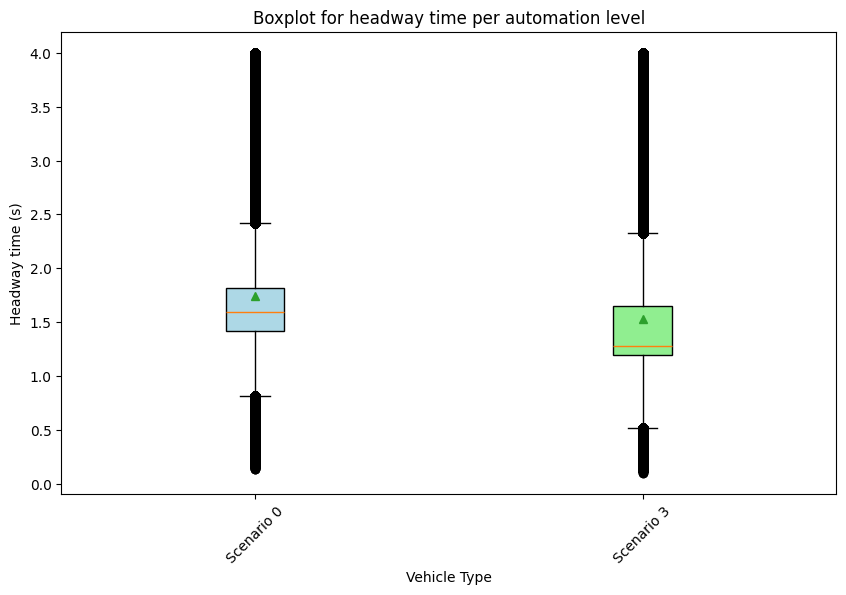

In [26]:
# show boxplots
show_headway_time_boxplot([df_gtu_0, df_gtu_3], ['Scenario 0', 'Scenario 3'])

### Vehicle grouping

In [27]:
# count string lengths
def determine_vehicle_string_lengths(data_list, labels, gap_threshold=10):
    # Dictionary to store string lengths by scenario and lane
    string_lengths = {label: {'LEFT': [], 'RIGHT': []} for label in labels}
    
    # Loop through each DataFrame in the data list
    for df_scen, label in zip(data_list, labels):
        # Only include main lanes
        main_lanes = ['LEFT', 'RIGHT']
        df = df_scen[df_scen['lane'].isin(main_lanes)].copy()
        
        # Group by each lane and time step to analyze vehicle positions within each lane at each time slice
        for (time, lane), time_lane_group in df.groupby(['time', 'lane']):
            # Sort vehicles by x_position within each (time, lane) group
            time_lane_group = time_lane_group.sort_values('x_position').reset_index(drop=True)
            
            # Calculate gaps between consecutive vehicles
            gaps = time_lane_group['x_position'].diff().fillna(0)
            
            # Find indexes where gaps exceed the threshold
            gap_indexes = gaps[gaps > gap_threshold].index
            
            # Calculate string lengths by subtracting gap indexes
            start_idx = 0
            current_string_lengths = []
            for gap_idx in gap_indexes:
                # Calculate length of string (number of vehicles) between gaps
                string_length = gap_idx - start_idx
                if string_length > 0:
                    current_string_lengths.append(string_length)
                start_idx = gap_idx  # Reset start index to the current gap
            
            # Include the final string after the last gap
            final_string_length = len(time_lane_group) - start_idx
            if final_string_length > 0:
                current_string_lengths.append(final_string_length)
            
            # Store string lengths for this lane and time in the current scenario
            if current_string_lengths:
                string_lengths[label][lane].extend(current_string_lengths)
    
    # Calculate mean string length per lane and scenario, then store in DataFrame
    mean_string_lengths = []
    for label in labels:
        for lane in main_lanes:
            # Calculate mean string length for this lane and scenario
            mean_length = sum(string_lengths[label][lane]) / len(string_lengths[label][lane]) if string_lengths[label][lane] else 0
            mean_string_lengths.append({'Scenario': label, 'Lane': lane, 'Mean_String_Length': mean_length})
    
    # Convert to DataFrame for easy analysis and plotting
    mean_string_lengths_df = pd.DataFrame(mean_string_lengths)
    
    return mean_string_lengths_df


def plot_vehicle_string_lengths(mean_string_lengths_df):
    # Colors and hatch patterns for lanes
    facecolor = 'white'
    hatches = [None, '///']  # No hatch for LEFT lane, hatch for RIGHT lane
    
    # Extract unique scenarios and lanes
    scenarios = mean_string_lengths_df['Scenario'].unique()
    lanes = mean_string_lengths_df['Lane'].unique()
    
    # Set up the bar width and positions
    bar_width = 0.35
    x = np.arange(len(scenarios))  # Label locations for each scenario

    # Create the figure
    plt.figure(figsize=(10, 6))
    
    # Plot each lane's mean string length as separate bars for each scenario
    for i, lane in enumerate(lanes):
        lane_data = mean_string_lengths_df[mean_string_lengths_df['Lane'] == lane]
        plt.bar(
            x + i * bar_width,
            lane_data['Mean_String_Length'],
            width=bar_width,
            color=facecolor,
            edgecolor='black',  # Outline to make the bars visible
            hatch=hatches[i],
            label=f'{lane} Lane'
        )
    
    # Add labels and title
    plt.xlabel('Scenario', fontsize=12)
    plt.ylabel('Mean Vehicle String Length', fontsize=12)
    plt.title('Mean Vehicle String Length by Scenario and Lane', fontsize=14)
    
    # Add scenario labels in the middle of each group of bars
    plt.xticks(x + bar_width / 2, scenarios, rotation=0)
    
    # Add legend
    plt.legend(title='Lane')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [28]:
df_mean_string_length = determine_vehicle_string_lengths([df_gtu_0, df_gtu_3], ['Scenario 0', 'Scenario 3'], gap_threshold=10)

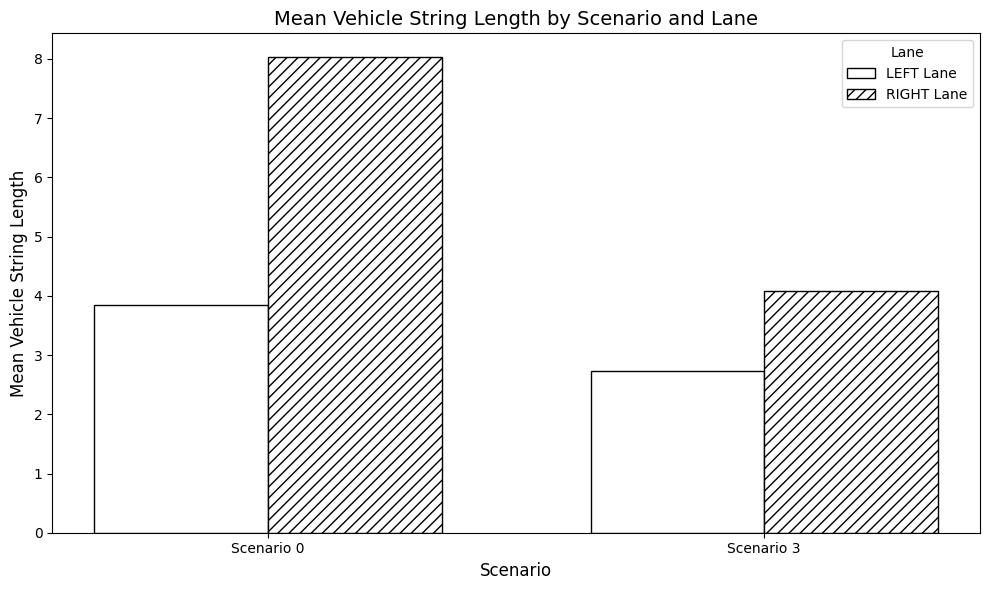

In [29]:
plot_vehicle_string_lengths(df_mean_string_length)

### Lane-changing

In [30]:
# get lane-chaning data
lc_variables = ['time', 'gtu_id', 'gtu_type', 'direction', 'link', 'from_lane']
df_lc_0 = load_scenario_dataframe(scenario_0, lc_variables, experiment_folder, lane_change_output, input_values)
df_lc_3 = load_scenario_dataframe(scenario_3, lc_variables, experiment_folder, lane_change_output, input_values)
# filter input parameters
df_lc_0 = df_lc_0[['seed', 'run'] + lc_variables]
df_lc_3 = df_lc_3[['seed', 'run'] + lc_variables]

In [36]:
# function to create lane-chaning dataframe
def create_lc_dataframe(gtu_data, lane_changes):
    # Step 1: Merge gtu_data with lane_changes to add lane change information (from_lane and direction)
    combined_df = pd.merge(
        gtu_data,
        lane_changes[['seed', 'run', 'time', 'gtu_id', 'from_lane', 'direction']],
        on=['seed', 'run', 'time', 'gtu_id'],
        how='left'
    )
    
    # Step 2: Select and rename columns as per your final structure, using leader and follower data directly from gtu_data
    combined_df = combined_df[
        ['run', 'seed', 'time', 'gtu_id', 'gtu_type', 'link', 'lane', 'from_lane', 'direction',
         'follower_gtu_id', 'leader_gtu_id', 'leader_gtu_type', 'headway_time', 'headway_distance']
    ]
    
    # Only include rows where a lane change has occurred
    combined_df = combined_df[combined_df['from_lane'].notna()]

    return combined_df

In [37]:
# get lane changing dataframe for the collected data
df_lc_data_0 = create_lc_dataframe(df_gtu_0, df_lc_0)
df_lc_data_3 = create_lc_dataframe(df_gtu_3, df_lc_3)

In [38]:
def show_lane_changes_per_section(data_list, labels):
    # Initialize a list to store mean lane change data for each scenario
    mean_lane_changes_all = []
    
    # Iterate through each dataframe in the data_list and its corresponding label
    for df, label in zip(data_list, labels):
        # Group by 'run', 'seed', and 'link' to get the number of lane changes per road section per run
        lane_changes_per_section = df.groupby(['run', 'seed', 'link']).size().reset_index(name='lane_change_count')
        
        # Calculate the mean number of lane changes per road section per simulation run
        mean_lane_changes = lane_changes_per_section.groupby(['link'])['lane_change_count'].mean().reset_index()
        
        # Add a column for the scenario label to identify each scenario in the plot
        mean_lane_changes['scenario'] = label
        
        # Append the result to the list
        mean_lane_changes_all.append(mean_lane_changes)
    
    # Concatenate all scenario results into one dataframe for plotting
    combined_df = pd.concat(mean_lane_changes_all)
    
    # Pivot data to make it suitable for grouped bar plotting
    pivot_data = combined_df.pivot(index='link', columns='scenario', values='lane_change_count')
    
    # Plot the data
    pivot_data.plot(kind='bar', figsize=(12, 8), width=0.7)
    
    # Customize the plot
    plt.xlabel('Road section (link)')
    plt.ylabel('Mean number of lane changes')
    plt.title('Mean number of lane changes per road section for different scenarios')
    plt.legend(title='Scenario')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

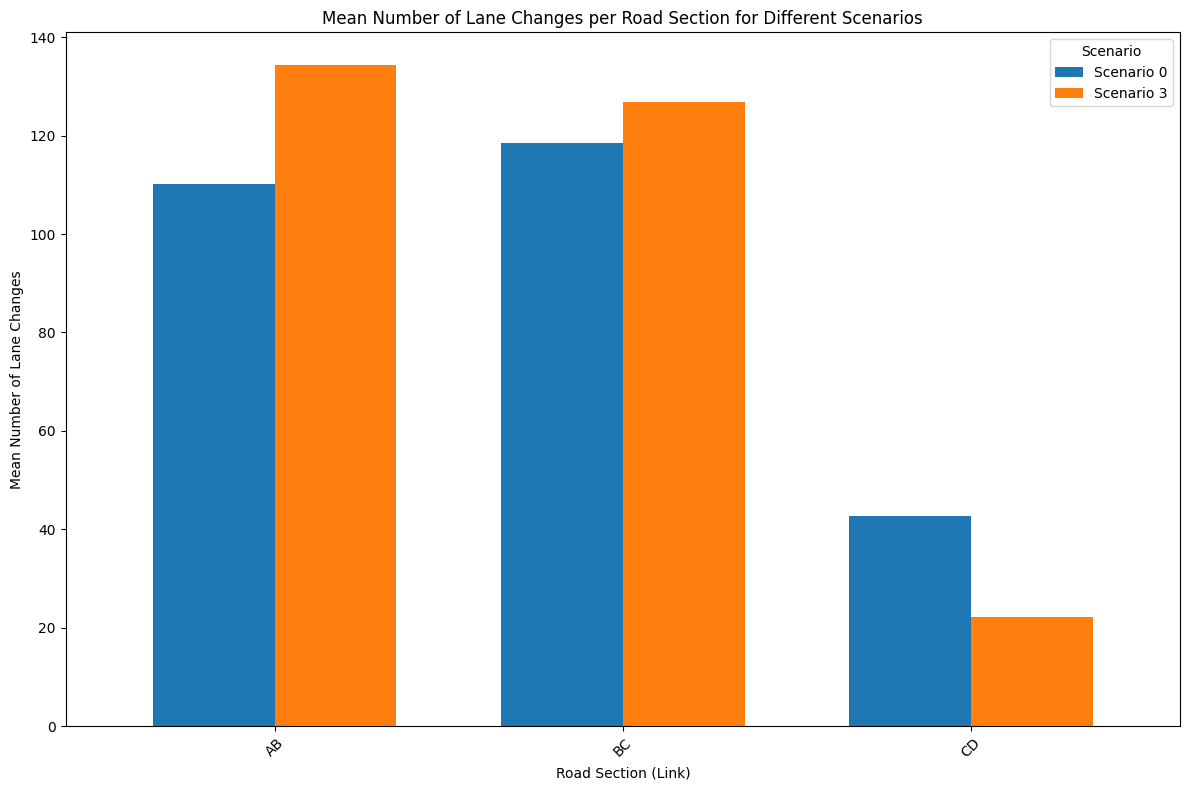

In [39]:
show_lane_changes_per_section([df_lc_data_0, df_lc_data_3], ['Scenario 0', 'Scenario 3'])